In [2]:
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import PIL
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
# Extract and confirm data
dataset_url = "data/cards/train"
data_dir = pathlib.Path(dataset_url).with_suffix("")

In [4]:
image_count = len(list(data_dir.glob("*/*.jpg")))
image_count

7624

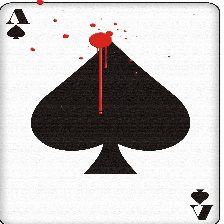

In [6]:
oval = list(data_dir.glob("ace of spades/*"))
PIL.Image.open(str(oval[1]))

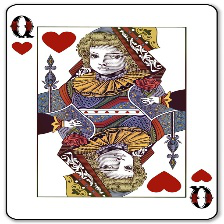

In [7]:
rectangle = list(data_dir.glob("queen of hearts/*"))
PIL.Image.open(str(rectangle[35]))

In [8]:
batch_size = 32
img_width = 200
img_height = 200

# Create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 7624 files belonging to 53 classes.
Using 6100 files for training.


In [9]:
# Create validation dataset

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 7624 files belonging to 53 classes.
Using 1524 files for validation.


In [10]:
# Create class names for plotting
class_names = train_ds.class_names
class_names

['ace of clubs',
 'ace of diamonds',
 'ace of hearts',
 'ace of spades',
 'eight of clubs',
 'eight of diamonds',
 'eight of hearts',
 'eight of spades',
 'five of clubs',
 'five of diamonds',
 'five of hearts',
 'five of spades',
 'four of clubs',
 'four of diamonds',
 'four of hearts',
 'four of spades',
 'jack of clubs',
 'jack of diamonds',
 'jack of hearts',
 'jack of spades',
 'joker',
 'king of clubs',
 'king of diamonds',
 'king of hearts',
 'king of spades',
 'nine of clubs',
 'nine of diamonds',
 'nine of hearts',
 'nine of spades',
 'queen of clubs',
 'queen of diamonds',
 'queen of hearts',
 'queen of spades',
 'seven of clubs',
 'seven of diamonds',
 'seven of hearts',
 'seven of spades',
 'six of clubs',
 'six of diamonds',
 'six of hearts',
 'six of spades',
 'ten of clubs',
 'ten of diamonds',
 'ten of hearts',
 'ten of spades',
 'three of clubs',
 'three of diamonds',
 'three of hearts',
 'three of spades',
 'two of clubs',
 'two of diamonds',
 'two of hearts',
 'two o

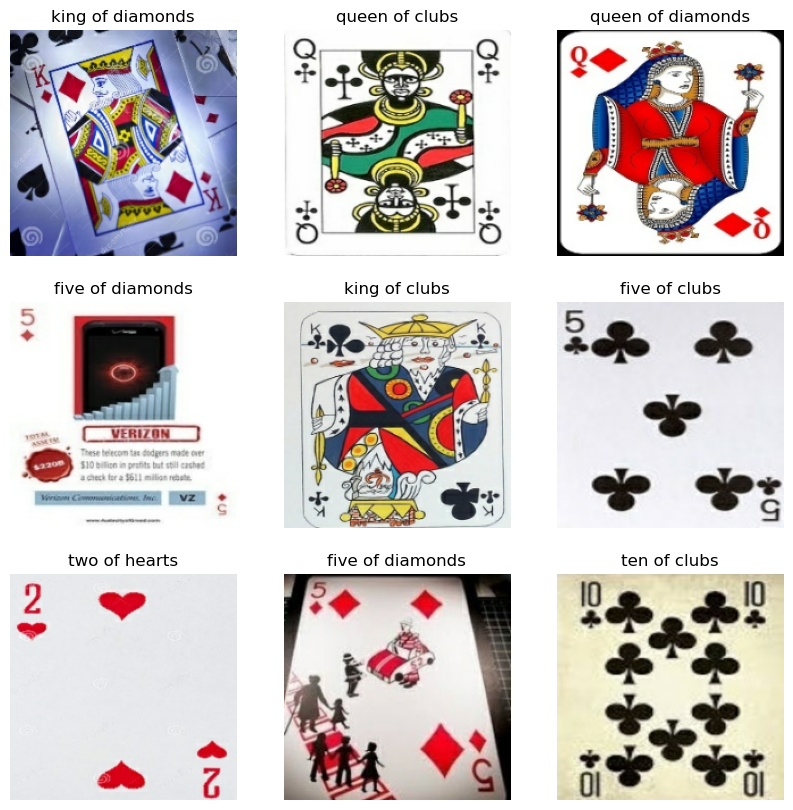

In [11]:
# Plot images to confirm they are labelled in the proper class
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
# Confirm proper shape of data to fit to model
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 200, 200, 3)
(32,)


In [13]:
#Configure dataset for performance w/ prefetch and autotune
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [14]:
# Normalize data by bringing RGB values down from range of 0-255 to a range of 0-1
normalization_layer = layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [16]:
# Create learning model (Sequential)

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [17]:
# Compile learning model
model.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ["accuracy"])

In [18]:
# Look at summary of model to confirm layers/parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        1

In [19]:
# Run learning model
epochs = 15

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs)

Epoch 1/15
191/191 [==============================] - 25s 131ms/step - loss: 2.8974 - accuracy: 0.2638 - val_loss: 2.1622 - val_accuracy: 0.4469
Epoch 2/15
191/191 [==============================] - 25s 130ms/step - loss: 1.6706 - accuracy: 0.5556 - val_loss: 1.7698 - val_accuracy: 0.5518
Epoch 3/15
191/191 [==============================] - 27s 139ms/step - loss: 0.8999 - accuracy: 0.7549 - val_loss: 1.8446 - val_accuracy: 0.5938
Epoch 4/15
191/191 [==============================] - 27s 141ms/step - loss: 0.3903 - accuracy: 0.8949 - val_loss: 1.9193 - val_accuracy: 0.6030
Epoch 5/15
191/191 [==============================] - 27s 142ms/step - loss: 0.1906 - accuracy: 0.9530 - val_loss: 2.2705 - val_accuracy: 0.6214
Epoch 6/15
191/191 [==============================] - 27s 142ms/step - loss: 0.1233 - accuracy: 0.9725 - val_loss: 2.2484 - val_accuracy: 0.6260
Epoch 7/15
191/191 [==============================] - 26s 134ms/step - loss: 0.0934 - accuracy: 0.9821 - val_loss: 2.5457 - val_ac

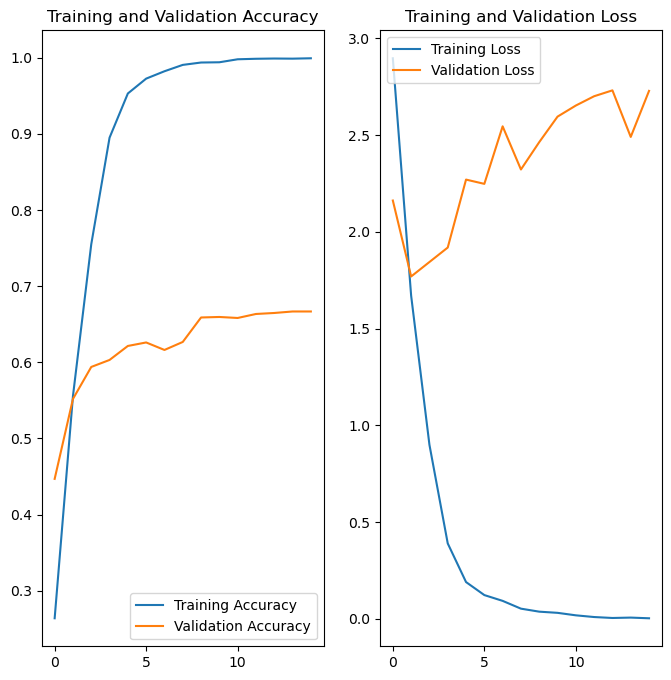

In [20]:
# Evaluate model performance
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = "Training Accuracy")
plt.plot(epochs_range, val_accuracy, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = "Training Loss")
plt.plot(epochs_range, val_loss, label = "Validation Loss")
plt.legend(loc = "upper left")
plt.title("Training and Validation Loss")

plt.show()